<a href="https://colab.research.google.com/github/tol/CSAPP2e/blob/master/MNIST_Hello_World_of_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST - Hello World of ML

Link to this colab: <font size="20">[goo.gl/qmSZbX](https://goo.gl/qmSZbX)</font>


In [0]:
#@title Pyton Imports and installing additional libs
import os
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
import PIL.Image
import numpy as np
from collections import defaultdict

print "tf.VERSION", tf.VERSION
print "keras.__version__", keras.__version__

tf.VERSION 1.13.1
keras.__version__ 2.2.4-tf


In [0]:
#@title Load the training and test data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print "Training data: ", x_train.shape
print "Test data: ", x_test.shape

11501568/11490434 [==============================] - 0s 0us/step
Training data:  (60000, 28, 28)
Test data:  (10000, 28, 28)


In [0]:
#@title Is GPU Available
print "is_gpu_available()", tf.test.is_gpu_available()

!uname -a
!nvidia-smi

is_gpu_available() True
Linux f7b17659600f 4.14.79+ #1 SMP Wed Dec 19 21:19:13 PST 2018 x86_64 x86_64 x86_64 GNU/Linux
Mon Mar 18 15:30:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    57W / 149W |    121MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+------------------------------------------------

In [0]:
#@title show_graph

from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import numpy as np
from google.colab import files

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [0]:
# Reading the training and eval data.

def normalize_images(x):
  return x / np.float32(255.0)

def train_input_fn(batch_size=64):
  """Prepare data for training."""
  ds = tf.data.Dataset.from_tensor_slices(
      (normalize_images(x_train),
       y_train.astype(np.int32)))
  # Iterate through the dataset a set number (`epochs_between_evals`) of times
  # during each training session.
  ds = ds.repeat(1)
  ds = ds.shuffle(buffer_size=50000)
  ds = ds.batch(batch_size, drop_remainder=True)
  return ds

def eval_input_fn(batch_size=64):
  ds = tf.data.Dataset.from_tensor_slices(
      (normalize_images(x_test), 
       y_test.astype(np.int32)))
  ds = ds.batch(batch_size, drop_remainder=True)
  return ds.make_one_shot_iterator().get_next()


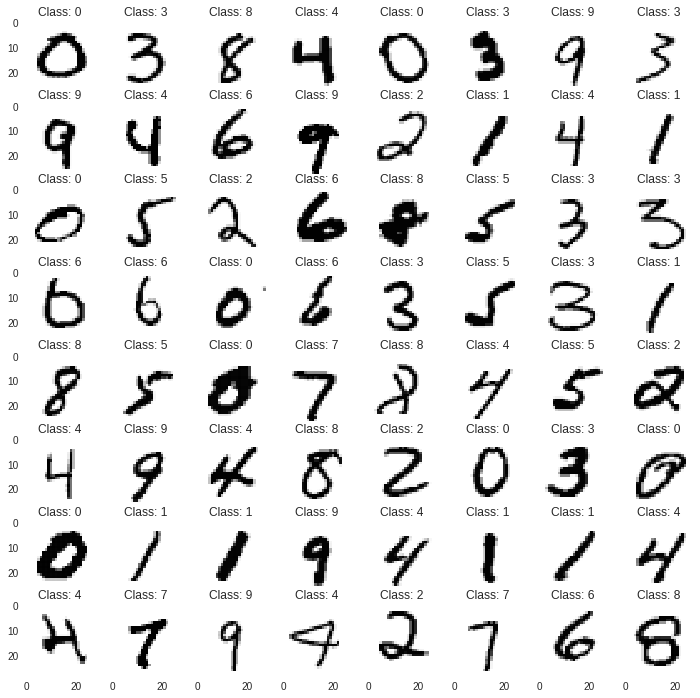

In [0]:
#@title DisplayTrainingData

def DisplayTrainingData():
  with tf.Graph().as_default():
    ds = train_input_fn(batch_size=8 * 8)
    it = ds.make_one_shot_iterator()
    e = it.get_next()
    with tf.Session() as sess:
      v = sess.run(e)
      f, ax = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(12, 12), edgecolor='b')
      for i in xrange(8):
        for j in xrange(8):
          idx = i * 8 + j
          ax[i, j].imshow(v[0][idx])
          ax[i, j].set_title("Class: %s" % v[1][idx])
          ax[i, j].grid(False)
        
DisplayTrainingData()

In [0]:
#@title Train the model

def create_slim_model(image, training=False):
  net = tf.reshape(image, [-1, 28, 28, 1])
  model = keras.Sequential([
    layers.Conv2D(32, (5, 5), padding='same', activation=tf.nn.relu),
    layers.MaxPool2D((2, 2), strides=2, padding='same'),
    layers.Conv2D(64, (5, 5), padding='same', activation=tf.nn.relu),
    layers.MaxPool2D((2, 2), strides=2, padding='same'),
    layers.Flatten(),
    layers.Dense(1024),
    layers.Dense(10),
    ])
  
  return model(net)
  
def model_fn(features, labels, mode, params):
  """The model_fn argument for creating an Estimator."""
#   model = create_model()
  model = create_slim_model
  image = features
  if isinstance(image, dict):
    image = features['image']
  

  if mode == tf.estimator.ModeKeys.PREDICT:
    logits = model(image, training=False)
    predictions = {
        'classes': tf.argmax(logits, axis=1),
        'probabilities': tf.nn.softmax(logits),
    }
    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.PREDICT,
        predictions=predictions,
        export_outputs={
            'classify': tf.estimator.export.PredictOutput(predictions)
        })
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

    logits = model(image, training=True)
    print logits
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    accuracy = tf.metrics.accuracy(
        labels=labels, predictions=tf.argmax(logits, axis=1))

    # Name tensors to be logged with LoggingTensorHook.
    tf.identity(LEARNING_RATE, 'learning_rate')
    tf.identity(loss, 'cross_entropy')
    tf.identity(accuracy[1], name='train_accuracy')

    # Save accuracy scalar to Tensorboard output.
    tf.summary.scalar('train_accuracy', accuracy[1])

    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.TRAIN,
        loss=loss,
        train_op=optimizer.minimize(loss, tf.train.get_or_create_global_step()))
  if mode == tf.estimator.ModeKeys.EVAL:
    logits = model(image, training=False)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    return tf.estimator.EstimatorSpec(
        mode=tf.estimator.ModeKeys.EVAL,
        loss=loss,
        eval_metric_ops={
            'accuracy':
                tf.metrics.accuracy(
                    labels=labels, predictions=tf.argmax(logits, axis=1)),
        })
  
  
mnist_classifier = tf.estimator.Estimator(
    model_fn=model_fn)

LEARNING_RATE = 0.001

mnist_classifier.train(input_fn=train_input_fn, steps=1000)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print('\nEvaluation results:\n\t%s\n' % eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f683c04b410>, '_model_dir': '/tmp/tmpO8HviM', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Calling model_fn.
Tensor("sequential/BiasAdd_3:0", shape=(64, 10), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:t

## Upload read image

Sample images to try: https://drive.google.com/open?id=1HS4WzyKFPKQstwAzXEiwNTtGB4bMc_LN

e.g. ![alt text](https://drive.google.com/uc?id=1E11IQJwlsylhKU_c8zNEVI1tmCBn1Dnh)

Saving mnist_sample_image.jpg to mnist_sample_image (1).jpg


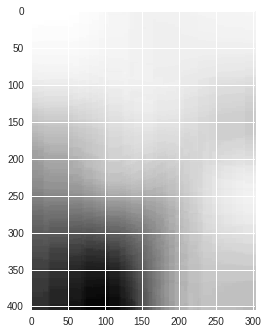

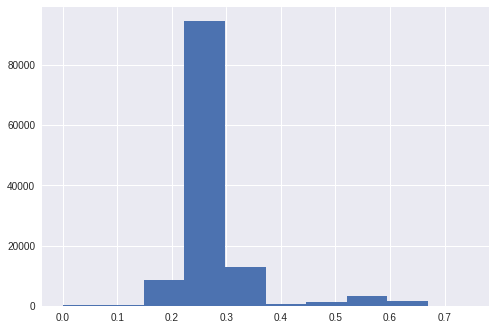

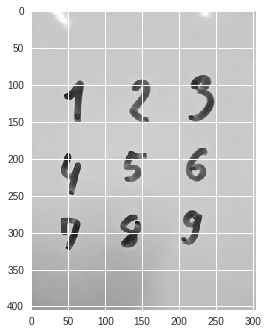

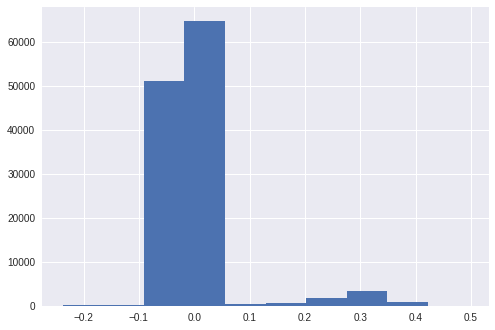

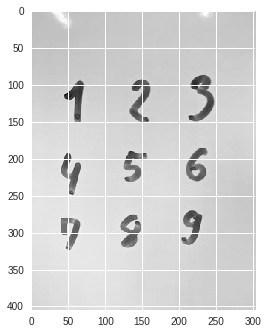

-0.23790854 0.4954248


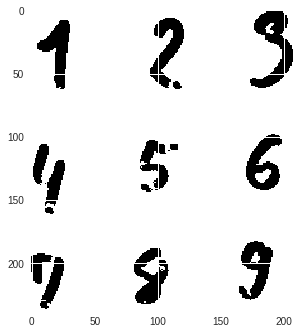

[ 30  76 105 162]


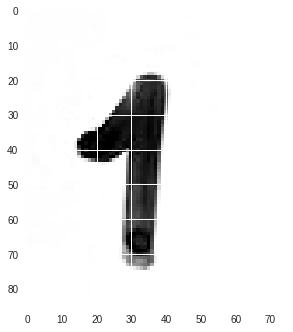

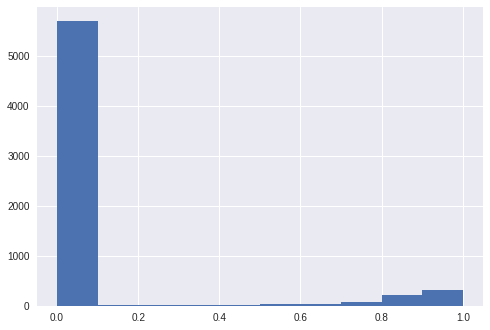

0.0 1.0
29.7
(28, 46)
(26, 26)


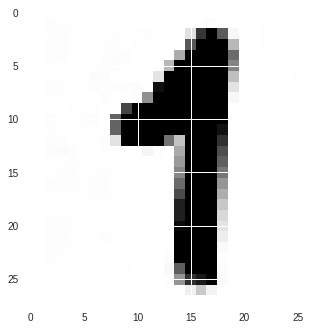

[105  76 180 162]


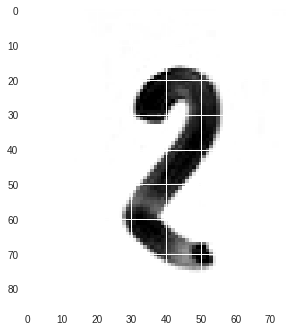

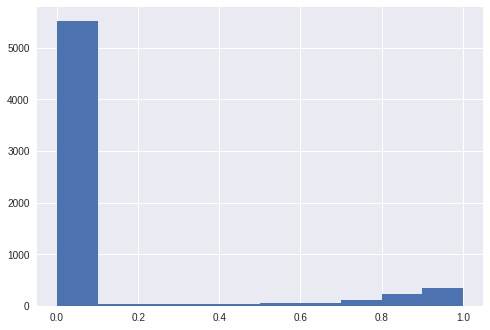

0.0 1.0
30.8
(42, 45)
(26, 26)


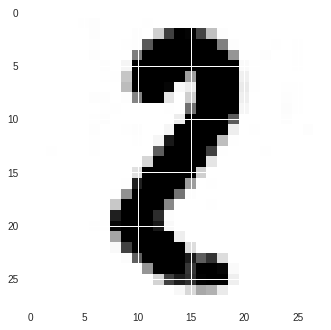

[180  76 255 162]


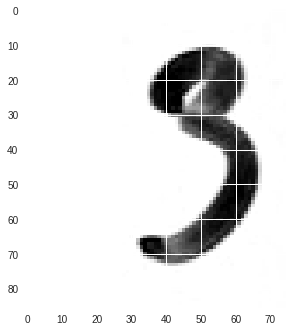

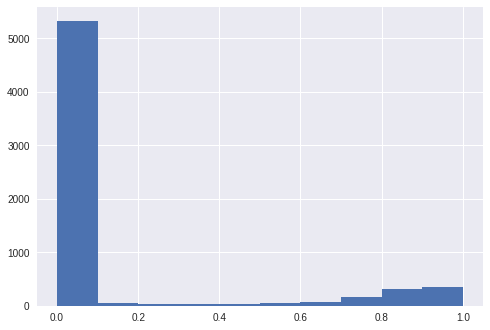

0.0 1.0
34.1
(50, 42)
(26, 26)


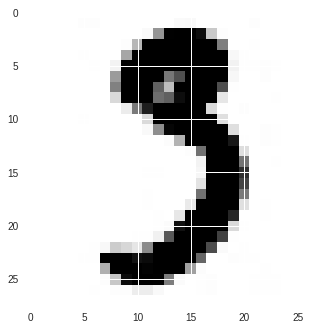

[ 30 162 105 248]


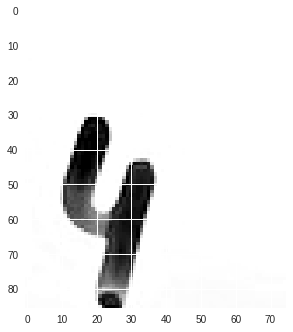

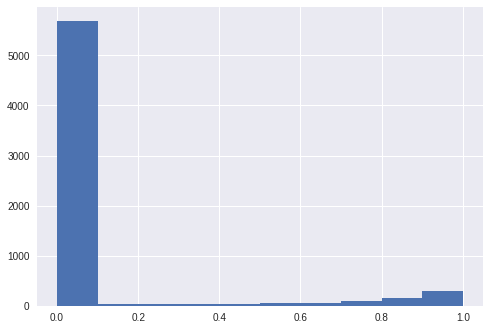

0.0 1.0
29.7
(24, 58)
(26, 26)


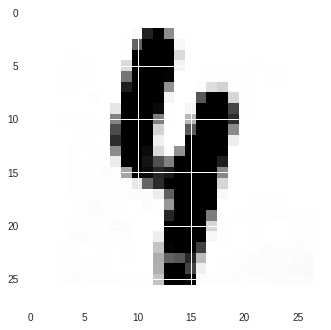

[105 162 180 248]


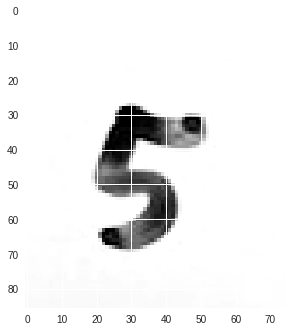

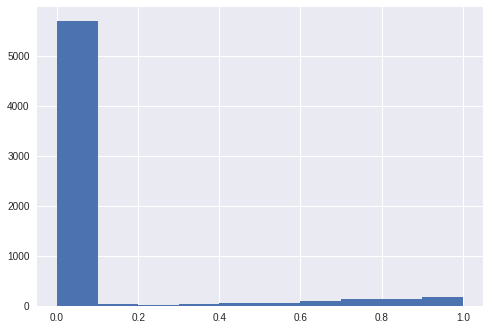

0.0 1.0
22.0
(36, 48)
(26, 26)


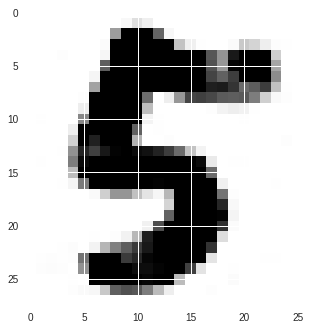

[180 162 255 248]


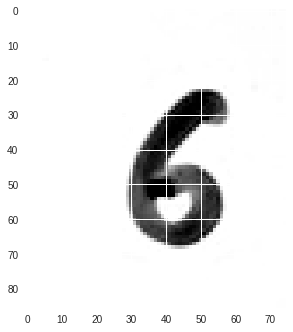

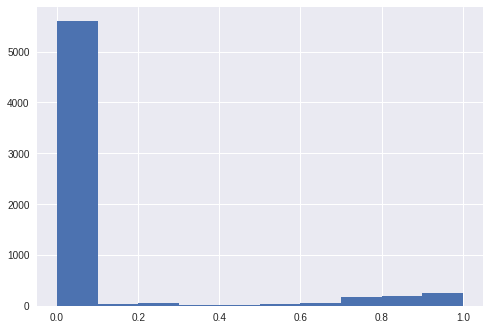

0.0 1.0
24.2
(43, 45)
(26, 26)


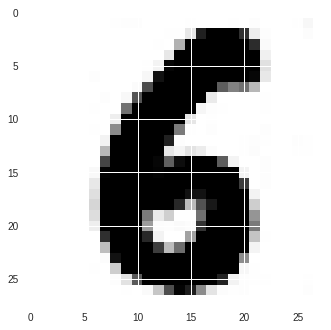

[ 30 248 105 334]


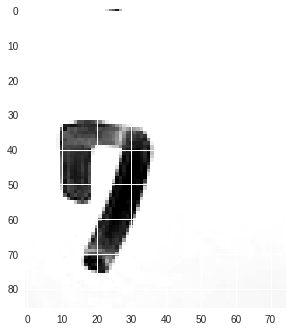

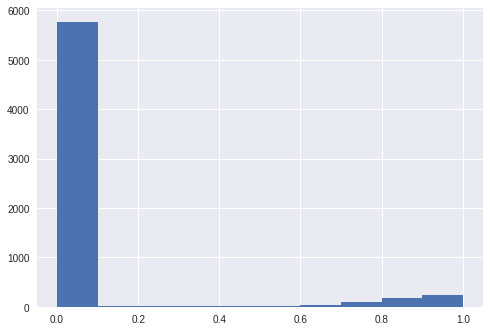

0.0 1.0
41.8
(23, 38)
(26, 26)


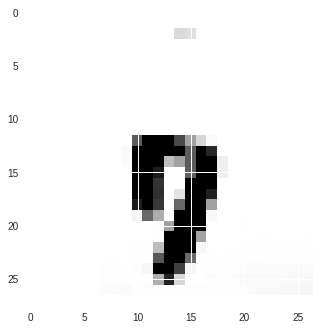

[105 248 180 334]


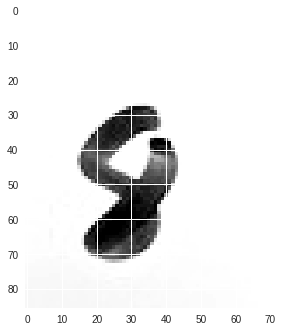

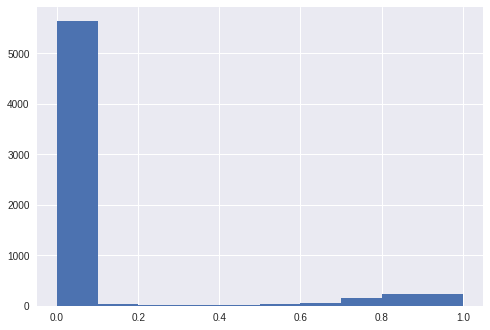

0.0 1.0
24.2
(29, 50)
(26, 26)


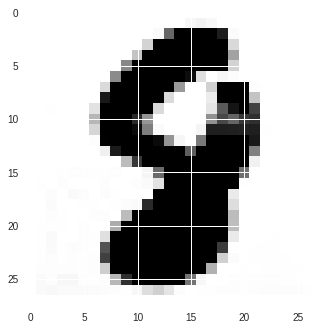

[180 248 255 334]


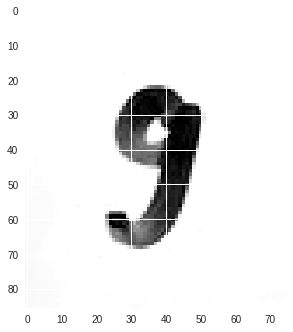

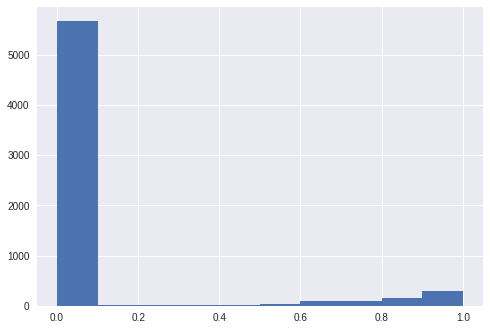

0.0 1.0
24.2
(37, 45)
(26, 26)


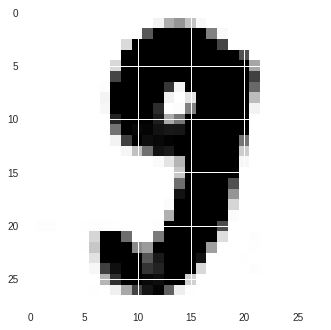

In [0]:
#@title Uploading Real image

# def upload_image_input_fn():
uploaded = files.upload()

def PILImageToNumpyImage(im):
  npim = np.array(im)
  npim = npim.astype(np.float32) / 255.0
  return npim

def RGBPILImageToNumpyImage(im):
  npim = PILImageToNumpyImage(im)
  npim = np.average(npim, -1)
  return 1 - npim


def Uploaded3x3ToImage(u):
  im_original = PIL.Image.open(BytesIO(u))
  im = im_original
  
  im_bg = im.resize((4, 4), resample=PIL.Image.BOX)
  im_bg = im_bg.resize(im.size, resample=PIL.Image.ADAPTIVE)
  npim_bg = RGBPILImageToNumpyImage(im_bg)
  plt.imshow(npim_bg)
  plt.show()
  
  npim = RGBPILImageToNumpyImage(im)
  plt.hist(npim.reshape(-1))
  plt.show()
  plt.imshow(npim)
  plt.show()
  
  npim = npim - npim_bg
  plt.hist(npim.reshape(-1))
  plt.show()
  plt.imshow(npim - npim_bg)
  plt.show()
  
  print npim.min(), npim.max()
  npim = npim > 0.2
  im = PIL.Image.fromarray(np.uint8(npim*255))
  x1, y1, x2, y2 = im.getbbox()
  plt.imshow(np.array(im.crop(im.getbbox())))
  plt.show()
  
  p1 = np.array([x1, y1])
  p2 = np.array([x2, y2])
  wh = p2 - p1
  wh5 = wh / 5
  p1 -= wh5 / 4
  p2 += wh5 / 4
  
  wh = p2 - p1
  wh3 = wh / 3
  for y in xrange(3):
    for x in xrange(3):
      p = np.array([x, y])
      small_box = np.concatenate(
          [p1 + wh3 * p,
           p1 + wh3 * (p + 1)])
      print small_box
      yield UploadImageToMNISTInput(im_original.crop(small_box))
  
#   s = max(box[2]-box[0], box[3]-box[1]) / 2 * 1.1
#   print s
#   center = ((box[2] + box[0]) / 2, (box[3] + box[1]) / 2)
#   print center
#   box = (center[0]-s, center[1]-s, center[0]+s, center[1] + s)
#   im = im.crop(box)
#   im = im.resize((26, 26), resample=PIL.Image.BOX)
#   npim = PILImageToNumpyImage(im)
#   print npim.shape
#   npim = npim * 1.5
#   npim = np.clip(npim, 0, 1)
  
#   npim = np.pad(npim, ((1, 1), (1, 1)), 'constant')
#   npim = np.expand_dims(npim, 0)
#   npim = np.expand_dims(npim, -1)
#   plt.imshow(np.squeeze(npim))
#   plt.show()
  
#   return npim

def UploadImageToMNISTInput(im):
#   im = PIL.Image.open(BytesIO(u))
  
#   im_bg = im.resize((4, 4), resample=PIL.Image.BOX)
#   im_bg = im_bg.resize(im.size, resample=PIL.Image.ADAPTIVE)
#   npim_bg = RGBPILImageToNumpyImage(im_bg)
#   plt.imshow(npim_bg)
#   plt.show()
  
  npim = RGBPILImageToNumpyImage(im)
#   plt.hist(npim.reshape(-1))
#   plt.show()
#   plt.imshow(npim)
#   plt.show()
  
#   npim = npim - npim_bg
#   plt.hist(npim.reshape(-1))
#   plt.show()
#   plt.imshow(npim - npim_bg)
#   plt.show()
  
  p_min = np.percentile(npim.reshape(-1), 70)
  p_max = np.percentile(npim.reshape(-1), 99)
  npim = (npim - p_min) / (p_max - p_min + 0.0001)
  npim = np.clip(npim, 0, 1)
  
  plt.imshow(npim)
  plt.show() 
  plt.hist(npim.reshape(-1))
  plt.show()
  
  print npim.min(), npim.max()
#   npim = npim > 0.
  im = PIL.Image.fromarray(np.uint8(npim*255))
  box = PIL.Image.fromarray(np.uint8((npim > 0.7) *255)).getbbox()
  s = max(box[2]-box[0], box[3]-box[1]) / 2 * 1.1
  print s
  center = ((box[2] + box[0]) / 2, (box[3] + box[1]) / 2)
  print center
  box = (center[0]-s, center[1]-s, center[0]+s, center[1] + s)
  im = im.crop(box)
  im = im.resize((26, 26), resample=PIL.Image.BOX)
  npim = PILImageToNumpyImage(im)
  print npim.shape
  npim = npim * 1.5
  npim = np.clip(npim, 0, 1)
  
  npim = np.pad(npim, ((1, 1), (1, 1)), 'constant')
  npim = np.expand_dims(npim, 0)
  npim = np.expand_dims(npim, -1)
  plt.imshow(np.squeeze(npim))
  plt.show()
  
  return npim
  
# UploadedToImage(uploaded[uploaded.keys()[1]])
  
data, labels = [], []
for k in uploaded:
#   label = int(k.split('.')[0])
  for i, npim in zip(xrange(9), Uploaded3x3ToImage(uploaded[k])):
    data.append(npim)
    labels.append(i + 1)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-18T15:42:49Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpO8HviM/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-18-15:42:49
INFO:tensorflow:Saving dict for global step 937: accuracy = 0.6666667, global_step = 937, loss = 0.92578095
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 937: /tmp/tmpO8HviM/model.ckpt-937

Evaluation results:
	{'loss': 0.92578095, 'global_step': 937, 'accuracy': 0.6666667}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpO8HviM/model.ckpt-937
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
----------------------------------------


Expected: 1 P

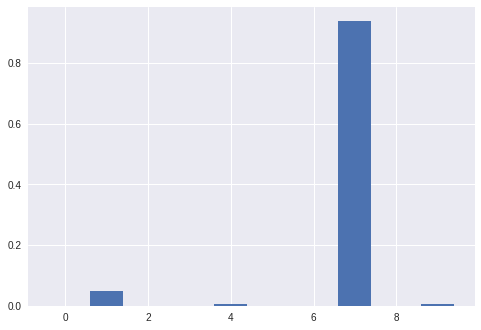

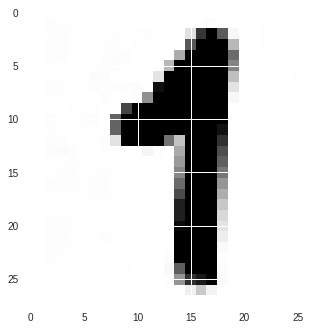

----------------------------------------


Expected: 7 Predicted: 5

  !!!!!!!!!!!!!
  !!! WRONG !!!
  !!!!!!!!!!!!!



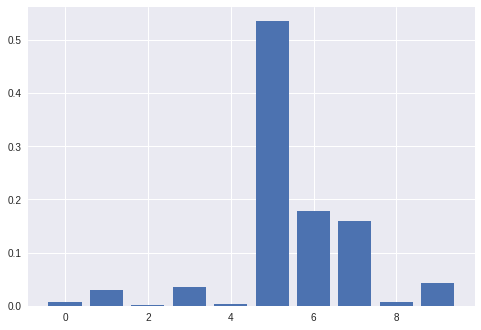

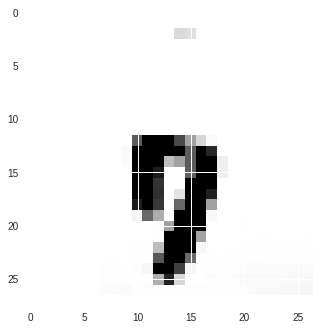

----------------------------------------


Expected: 8 Predicted: 9

  !!!!!!!!!!!!!
  !!! WRONG !!!
  !!!!!!!!!!!!!



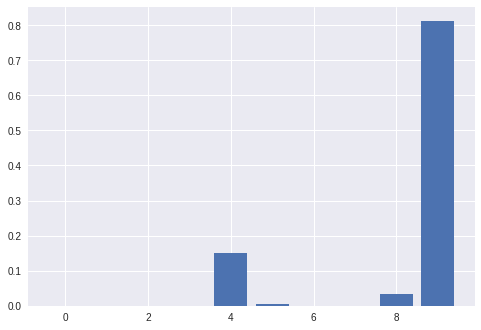

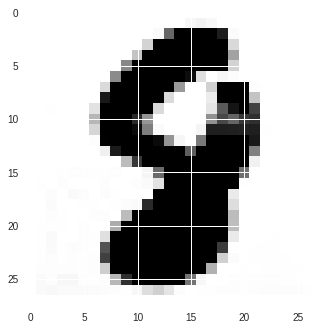

In [0]:
def upload_image_input_fn():
  return tf.data.Dataset.from_tensors(np.concatenate(data))

def upload_image_input_with_labelsfn():
  return tf.data.Dataset.from_tensors((np.concatenate(data), np.array(labels)))

eval_results = mnist_classifier.evaluate(input_fn=upload_image_input_with_labelsfn)
print('\nEvaluation results:\n\t%s\n' % eval_results)

prediction = list(mnist_classifier.predict(input_fn=upload_image_input_fn))
for p, d, l in zip(prediction, data, labels):
  if l == p['classes']:
    continue

  print "-" * 40
  print
  print
  print "Expected: %d Predicted: %d" % (l, p['classes'])
  if l != p['classes']:
    print
    print "  !!!!!!!!!!!!!"
    print "  !!! WRONG !!!"
    print "  !!!!!!!!!!!!!"
    print

  plt.bar(xrange(10), p['probabilities'])
  plt.show()
  plt.imshow(np.squeeze(d))
  plt.show()

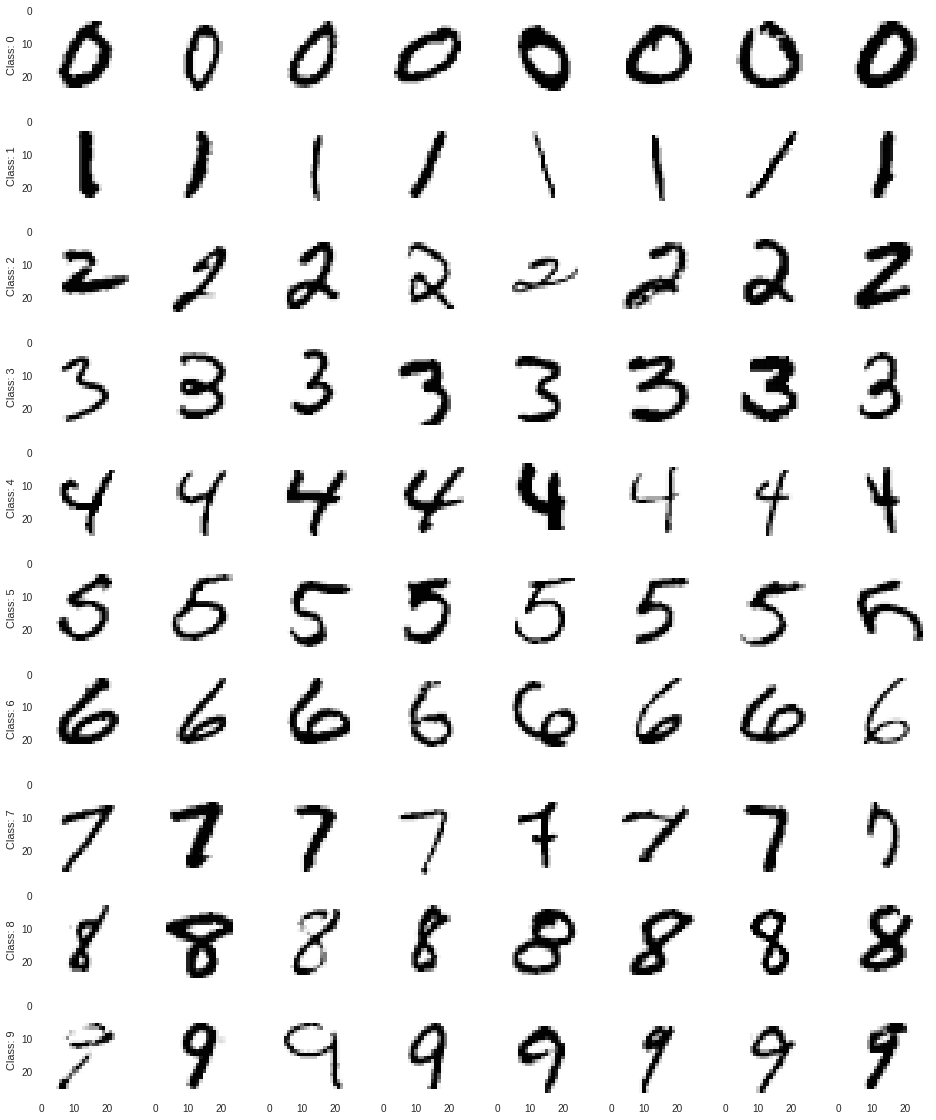

In [0]:
#@title DisplayTrainingDataPerClass

def DisplayTrainingDataPerClass(examples_per_class=8):
  images_per_class = defaultdict(list)
  with tf.Graph().as_default():
    ds = train_input_fn(batch_size=examples_per_class)
    it = ds.make_one_shot_iterator()
    e = it.get_next()
    with tf.Session() as sess:
      while True:
        v = sess.run(e)
        for i in xrange(len(v[0])):
          if len(images_per_class[v[1][i]]) < examples_per_class:
            images_per_class[v[1][i]].append(v[0][i])
        if min(map(len, images_per_class.values())) >= examples_per_class:
          break
          
    classes_cnt = len(images_per_class)
    f, ax = plt.subplots(classes_cnt, examples_per_class,
                         sharex=True, sharey=True,
                         figsize=(examples_per_class*2, classes_cnt * 2),
                         edgecolor='b')
    for i in xrange(classes_cnt):
      ax[i, 0].set_ylabel("Class: %s" % i)
      for j in xrange(examples_per_class):
        ax[i, j].imshow(images_per_class[i][j].reshape([28, 28]))
#         ax[i, j].set_title("Class: %s" % i)
        ax[i, j].grid(False)
  
DisplayTrainingDataPerClass()


## Resources I recommend:
* Basics of NN:
    * [Neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) by 3Blue1Brown on YouTube
    * Welsch Labs on YouTube
        * [Learning To See](https://www.youtube.com/playlist?list=PLiaHhY2iBX9ihLasvE8BKnS2Xg8AhY6iV)
        * [Neural Networks Demystified](https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU)
* Courses:
   * [Machine Learning Crash Course with TensorFlow APIs](https://developers.google.com/machine-learning/crash-course/) by Google
   *  [CS231n Winter 2016](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC) by Andrej Karpathy or [by Stanford](http://cs231n.stanford.edu/)
   * Coursera [Machine Learning](https://www.coursera.org/learn/machine-learning) by Andrew Ng
* http://tools.google.com/seedbank - example Colabs by Google
* https://www.tensorflow.org/tutorials

 and MANY more out there...

# Playground

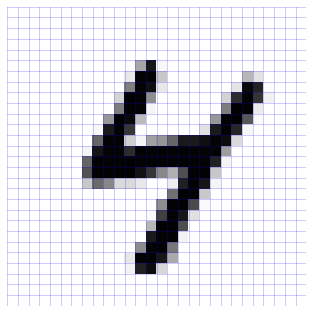

In [0]:
#@title Load an image for animations

g = tf.Graph()
with g.as_default():
  ds = train_input_fn(batch_size=1)
  it = ds.make_one_shot_iterator()
  e = it.get_next()
  
sess = tf.Session(graph=g)
v = sess.run(e)

ax = plt.gca()
ax.set_xticks(np.arange(-0.5, 28.5, 1))
ax.set_yticks(np.arange(-0.5, 28.5, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid(color='b', alpha=0.2)

im1_data = v[0][0]
plt.imshow(im1_data)

In [0]:
from matplotlib import animation, rc
from google.colab import files

# !pip install Wand
# !apt-get install libmagickwand-dev
!apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

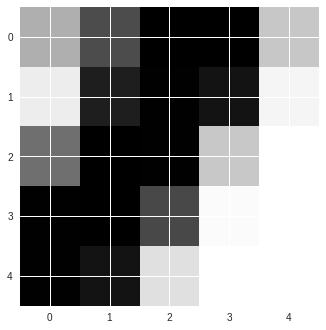

In [0]:
conv_filter_pos = (15, 15)
conv_filter = im1_data[conv_filter_pos[0]:conv_filter_pos[0]+5, conv_filter_pos[1]:conv_filter_pos[1]+5]
plt.imshow(conv_filter)

In [0]:
#@title Conv2D animation

# First set up the figure, the axes, and the plot element
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
plt.close()

ax[0].set_xticks(np.arange(-0.5, 28.5, 1))
ax[0].set_yticks(np.arange(-0.5, 28.5, 1))
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].grid(color='b', alpha=0.2)

im1 = ax[0].imshow(im1_data)

rnd_im = np.random.random([28, 28, 3])
im2 = ax[0].imshow(
    rnd_im,
    cmap=plt.cm.viridis, alpha=.1, animated=True)

ax[0].imshow(v[0][0].reshape([28, 28]))

im2_data = np.zeros((28, 28, 4))
im2 = ax[0].imshow(
    im2_data,
    cmap=plt.cm.viridis, alpha=1.0, animated=True)

ax[1].set_xticks(np.arange(-0.5, 28.5 - 5, 1))
ax[1].set_yticks(np.arange(-0.5, 28.5 - 5, 1))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].grid(color='b', alpha=0.2)


im3_data = np.zeros((28 - 5, 28 - 5, 3))
im3 = ax[1].imshow(im3_data, animated=True)

# initialization function: plot the background of each frame
def init():
    return (im1, im2, im3)

def animate(i):
#   i = i + 25 * 14
  y = i % (28 - 5)
  x = i // (28 - 5)

  im2_data[:,:] = 0.0
  
  im2_data[x:x+5, y:y+5, 2] = 1.0
  im2_data[x:x+5, y:y+5, 3] = conv_filter * 0.8 + 0.2
  im2.set_array(im2_data)

  im1_patch = im1_data[x:x+5, y:y+5]
  v = np.average((1 - im1_patch) * (1 - conv_filter * 2))
  v = v * 1.5
  im3_data[x, y] = np.clip(v + 0.5, 0.0, 1.0)
  im3.set_array(im3_data)
  
  plt.draw()
  
  return (im1, im2, im3)

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=(28-5) * (28 - 5),
    interval=25, blit=True)
rc('animation', html='jshtml')
anim

<Figure size 576x396 with 0 Axes>

In [0]:
#@title Write animation as mp4
from google.colab import files
!apt-get install ffmpeg 

Writer = animation.FFMpegWriter
writer = Writer(fps=15, bitrate=1800)
name='conv2d.mp4'
anim.save(name, writer=writer)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.3.4-2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
files.download(name)